In [1]:
import pandas as pd
import numpy as np
import gc
import open3d as o3d
import os, shutil
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import transforms3d
import copy
import cv2
from multiprocessing import Pool, cpu_count

In [2]:
OUT_PATH = "/home/saby/Projects/ati/data/data/datasets/Carla/64beam-Data/dynamic/12/_out"
GT_PATH = "/home/saby/Projects/ati/data/data/datasets/Carla/64beam-Data/dynamic/12/groundTruth.csv"
TRAJ_PATH = "/home/saby/Projects/vanshil/for_ate_rpe/pbstream_to_csv/mask_dynamic_pcd_run12_gt.csv"

OUTPUT_PATH = "/home/saby/Projects/ati/data/data/datasets/Carla/64beam-Data/dynamic/12/simulate_run_static_only"
OUTPUT_VIDEO_PATH = "/home/saby/Projects/ati/data/data/datasets/Carla/64beam-Data/dynamic/12/simulate_run_static_only.avi"

In [3]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
else:
    shutil.rmtree(OUTPUT_PATH)
    os.makedirs(OUTPUT_PATH)

In [4]:
def getint(name):
    try:
        return int(name.split('.')[0])
    except Exception as e:
        print(e)
        print("at name ", name)
        assert False

############ THESE HAVE BEEN TESTED ON 2D MOTIONS ONLY !!!
# Function to get transformation matrix for a given pose
def pose2matrix(translation_list, rotation_angle_list, zoom_list=[1,1,1]):
    # trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom_vec = np.array(zoom_list)
    # transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom_vec)
    transform_mat = transforms3d.affines.compose(translation_list, rot_mat, zoom_list)
    return transform_mat

def matrix2pose(gt_pose):
    trans_arr, rot_mat, scale_mat, shear_mat = transforms3d.affines.decompose44(gt_pose)
    rot_arr = np.array([np.rad2deg(ang) for ang in transforms3d.euler.mat2euler(rot_mat, axes='sxyz')])
    return trans_arr, rot_arr

def draw_pcd(pcd, where='mat_3d'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.grid()
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1])
        plt.grid()
        plt.show()

In [5]:
out_pcd_files = sorted(os.listdir(OUT_PATH), key=getint)
len(out_pcd_files)

7204

In [6]:
df_gt = pd.read_csv(GT_PATH)
df_gt.shape

(7196, 28)

In [7]:
df_gt = df_gt[['step', 'location_x', 'location_y', 'location_z', 'rotation_roll', 'rotation_pitch', 'rotation_yaw']]
df_gt.shape

(7196, 7)

In [8]:
df_traj = pd.read_csv(TRAJ_PATH)
df_traj.shape

(2883, 8)

In [9]:
df_traj['step'] = ((df_traj['timestamp'] * 10).round()).astype(int)
df_traj.shape

(2883, 9)

In [10]:
df_gt.head()

,step,location_x,location_y,location_z,rotation_roll,rotation_pitch,rotation_yaw
0,1,88.619987,103.379997,39.430626,0.000000e+00,0.0,90.000046
1,2,88.619987,103.379997,39.373486,3.778308e-13,0.0,90.000076
2,3,88.619987,103.379997,39.218460,3.778308e-13,0.0,90.000076
3,4,88.619987,103.379997,38.965645,3.778308e-13,0.0,90.000076
4,5,88.619987,103.379997,38.615139,3.778308e-13,0.0,90.000076


In [11]:
df_traj.head()

,timestamp,x,y,z,q_x,q_y,q_z,q_w,step
0,0.099994,-0.184175,0.010689,-0.049200,0.999475,-0.032020,0.001306,0.004780,1
1,0.499994,-0.111941,0.037637,-0.065175,0.999475,-0.032024,0.001305,0.004782,5
2,0.600000,-0.092001,0.043049,-0.068682,0.999475,-0.032031,0.001303,0.004786,6
3,1.200000,0.042635,0.065037,-0.086987,0.999474,-0.032042,0.001301,0.004792,12
4,1.800000,0.223877,0.073447,-0.098332,0.999474,-0.032057,0.001308,0.004799,18


In [12]:
gt_set = set(df_gt['step'])
traj_set = set(df_traj['step'])
match_set = gt_set.intersection(traj_set)
len(match_set)

2883

In [13]:
df_merged = pd.merge(df_gt, df_traj, how='inner', on='step')
df_merged.shape

(2883, 15)

In [14]:
df_merged.head()

,step,location_x,location_y,location_z,rotation_roll,rotation_pitch,rotation_yaw,timestamp,x,y,z,q_x,q_y,q_z,q_w
0,1,88.619987,103.379997,39.430626,0.000000e+00,0.000000,90.000046,0.099994,-0.184175,0.010689,-0.049200,0.999475,-0.032020,0.001306,0.004780
1,5,88.619987,103.379997,38.615139,3.778308e-13,0.000000,90.000076,0.499994,-0.111941,0.037637,-0.065175,0.999475,-0.032024,0.001305,0.004782
2,6,88.619987,103.379997,38.169399,0.000000e+00,0.000000,90.000053,0.600000,-0.092001,0.043049,-0.068682,0.999475,-0.032031,0.001303,0.004786
3,12,88.620079,103.380264,38.091503,-5.145263e-02,0.049191,90.000114,1.200000,0.042635,0.065037,-0.086987,0.999474,-0.032042,0.001301,0.004792
4,18,88.620117,103.379990,38.103008,-4.241943e-03,0.004405,90.000137,1.800000,0.223877,0.073447,-0.098332,0.999474,-0.032057,0.001308,0.004799


In [15]:
first_pose = df_merged.iloc[0]
first_pose

step                1.000000
location_x         88.619987
location_y        103.379997
location_z         39.430626
rotation_roll       0.000000
rotation_pitch      0.000000
rotation_yaw       90.000046
timestamp           0.099994
x                  -0.184175
y                   0.010689
z                  -0.049200
q_x                 0.999475
q_y                -0.032020
q_z                 0.001306
q_w                 0.004780
Name: 0, dtype: float64

In [16]:
trans_gt_list = [first_pose['location_x'], first_pose['location_y'], 0]
rot_gt_list   = [0, 0, first_pose['rotation_yaw']]
first_gt_pose_transform = pose2matrix(trans_gt_list, rot_gt_list,)
first_gt_pose_transform

array([[-7.98948327e-07, -1.00000000e+00,  0.00000000e+00,
         8.86199875e+01],
       [ 1.00000000e+00, -7.98948327e-07,  0.00000000e+00,
         1.03379997e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [17]:
# USE THIS

quaternion_traj_list = [first_pose['q_w '], first_pose['q_x'], first_pose['q_y'], first_pose['q_z']]
angles_traj_list = transforms3d.euler.quat2euler(quaternion_traj_list, axes='sxyz')

trans_traj_list = [first_pose['x'], first_pose['y'], 0]
rot_traj_list   = [0, 0, np.rad2deg(angles_traj_list[-1])]
first_traj_pose_transform = pose2matrix(trans_traj_list, rot_traj_list)
first_traj_pose_transform

array([[ 0.99795025,  0.06399456,  0.        , -0.184175  ],
       [-0.06399456,  0.99795025,  0.        ,  0.0106894 ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
step_list = []

x_gt_list = []
y_gt_list = []
yaw_gt_list = []
gt_pose_transform_local_list = []

x_traj_list = []
y_traj_list = []
yaw_traj_list = []
traj_pose_transform_local_list = []

for idx, row in tqdm_notebook(df_merged.iterrows(), total=df_merged.shape[0]):
    step_list.append(row['step'])
    trans_gt_list = [row['location_x'], row['location_y'], 0]
    rot_gt_list   = [0, 0, row['rotation_yaw']]
    gt_pose_transform = pose2matrix(trans_gt_list, rot_gt_list)
    gt_pose_transform_local = np.matmul(np.linalg.inv(first_gt_pose_transform), gt_pose_transform)

    trans_gt_local_arr, rot_gt_local_arr = matrix2pose(gt_pose_transform_local)
    x_gt_list.append(trans_gt_local_arr[0])
    y_gt_list.append(trans_gt_local_arr[1])
    yaw_gt_list.append(rot_gt_local_arr[-1])
    gt_pose_transform_local_list.append(gt_pose_transform_local)

    quaternion_traj_list = [row['q_w '], row['q_x'], row['q_y'], row['q_z']]
    angles_traj_list = transforms3d.euler.quat2euler(quaternion_traj_list, axes='sxyz')
    trans_traj_list = [row['x'], row['y'], 0]
    rot_traj_list   = [0, 0, np.rad2deg(angles_traj_list[-1])]
    traj_pose_transform = pose2matrix(trans_traj_list, rot_traj_list)
    traj_pose_transform_local = np.matmul(np.linalg.inv(first_traj_pose_transform), traj_pose_transform)

    trans_traj_local_arr, rot_traj_local_arr = matrix2pose(traj_pose_transform_local)
    x_traj_list.append(trans_traj_local_arr[0])
#         y_traj_list.append(trans_traj_local_arr[1])
    y_traj_list.append(-trans_traj_local_arr[1])
    yaw_traj_list.append(rot_traj_local_arr[-1])
    traj_pose_transform_local_list.append(traj_pose_transform_local)

/home/saby/anaconda3/envs/ati/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [19]:
e_x = np.array(x_traj_list) - np.array(x_gt_list)
e_y = np.array(y_traj_list) - np.array(y_gt_list)

vehicle_x = np.array(x_gt_list) - e_x
vehicle_y = np.array(y_gt_list) - e_y

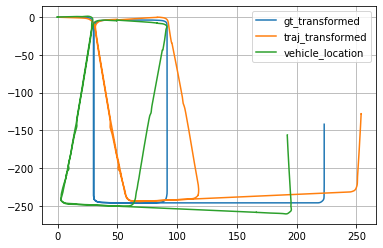

In [20]:
plt.figure()
plt.grid()
# plt.plot(df_gt['location_x'], df_gt['location_y'], label='gt')
plt.plot(x_gt_list, y_gt_list, label='gt_transformed')
plt.plot(x_traj_list, y_traj_list, label='traj_transformed')
plt.plot(vehicle_x, vehicle_y, label='vehicle_location')
# plt.plot(df_traj['x'], df_traj['y'], label='traj')
plt.legend()

In [21]:
def correct_for_z(this_pcd):
    pcd = copy.deepcopy(this_pcd)
    pt_arr = np.asarray(pcd.points)
    new_pt_arr = np.array([np.array([-y,x,-z]) for x, y, z in pt_arr])
    pcd.points = o3d.utility.Vector3dVector(new_pt_arr)
    return pcd

In [22]:
VOXEL_SZ = 0.02

In [23]:
def parallel_thread(idx):
    gt_transform = pose2matrix([x_gt_list[idx], y_gt_list[idx], 0], [0,0,yaw_gt_list[idx]])
    fname = str(int(step_list[idx])) + ".ply"
    out_path = os.path.join(OUT_PATH, fname)
    this_pcd = o3d.io.read_point_cloud(out_path)
    this_pcd = this_pcd.voxel_down_sample(VOXEL_SZ)
    this_pcd = correct_for_z(this_pcd)
    this_arr = np.asarray(this_pcd.points)
    pt_arr = np.concatenate((this_arr, np.ones((this_arr.shape[0],1))), axis=-1).T
    transform_arr = np.matmul(gt_transform, pt_arr).T[:,:3]
    
    plt.figure(figsize=(20,20))
#     axes = plt.gca()
#     axes.set_xlim([-120,120])
#     axes.set_ylim([-120,120])
    plt.grid()
    plt.plot(transform_arr[:,0], transform_arr[:,1], '.', c='b', label='local_lidar_points')
    plt.plot(x_gt_list[idx], y_gt_list[idx], '*', c='g', label='gt_location')
    plt.plot(x_gt_list[:idx+1], y_gt_list[:idx+1], c='g', label='gt_path')
#     plt.plot(x_traj_list[:idx+1], y_traj_list[:idx+1], label='traj_transformed')
    plt.plot(vehicle_x[idx], vehicle_y[idx], '*', c='r', label='vehicle_location')
    plt.plot(vehicle_x[:idx+1], vehicle_y[:idx+1], c='r', label='vehicle_path')
    plt.legend()
    img_fname = str(idx) + ".png"
    img_path = os.path.join(OUTPUT_PATH, img_fname)
    plt.savefig(img_path)
    plt.close()
#     break

In [24]:
parallel_args = range(len(x_gt_list))
process_pool = Pool(cpu_count()-1)
__ = [each for each in tqdm_notebook(process_pool.imap(parallel_thread,
                                                       parallel_args),
                                     total = len(parallel_args))]
process_pool.terminate()
gc.collect()

/home/saby/anaconda3/envs/ati/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


12

In [25]:
# USE THIS

video_path = OUTPUT_VIDEO_PATH

imgs_path = os.path.join(OUTPUT_PATH)

img_files = sorted(os.listdir(imgs_path), key=getint)

some_file_path = os.path.join(OUTPUT_PATH, img_files[0])
some_img = cv2.imread(some_file_path)
height, width, layers = some_img.shape

video_size = (width,height)
video_fps  = 10

out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'DIVX'), video_fps, video_size)

for img_file in tqdm_notebook(img_files):
    merged_file_path = os.path.join(OUTPUT_PATH, img_file)
    merged_img_arr = cv2.imread(merged_file_path)
    out.write(merged_img_arr)

out.release()

/home/saby/anaconda3/envs/ati/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()
